###### -----------------START--------------------------------------------

In [1]:
import json

In [2]:
import os

In [3]:
from tqdm import tqdm

In [4]:
train_file_path = '/home/aritra/cric/train_questions.json'
val_file_path = '/home/aritra/cric/val_questions.json'

In [5]:
# Training Set

with open(train_file_path, "r") as file:
     train_json = json.load(file)

In [6]:
# Validation Set

with open(val_file_path, "r") as file:
     val_json = json.load(file)

In [7]:
len(train_json)

365235

In [8]:
len(val_json)

43112

In [9]:
train_json[10]['question']

'which object on the floor can holds flowers'

In [10]:
val_json[10]['question']

'what is the color of the object that is behind the piano and can keep light out of a room'

##### Processing of Training Set

In [11]:
questionList = []
answerList = []
imgList = []

In [12]:
train_json[2]['image_id']

1005

#### iter 1: from 0 , 149000 -> error1.txt -> 159
#### iter 2: from 150000 , 240000 -> error2.txt -> 34
#### iter 3: from 240000 , 365235 ->error3.txt -> 121

In [13]:
# verifying
indexToExclude = []

with open('error1.txt', 'r') as file:
    for line in file:
        number = int(line.strip())
        indexToExclude.append(number)
        
with open('error2.txt', 'r') as file:
    for line in file:
        number = int(line.strip())
        indexToExclude.append(number)
        
with open('error3.txt', 'r') as file:
    for line in file:
        number = int(line.strip())
        indexToExclude.append(number)

In [14]:
len(indexToExclude)

314

In [15]:
for i in tqdm(range(len(train_json))):
    
    if i in indexToExclude:
        continue
        
    pointer = train_json[i]
    
    questionList.append(pointer['question'])
    answerList.append(pointer['answer'])
    imgList.append(pointer['image_id'])

100%|███████████████████████████████████| 365235/365235 [00:01<00:00, 332945.95it/s]


In [16]:
len(questionList), len(answerList), len(imgList)

(364921, 364921, 364921)

In [17]:
questionList = questionList[0:4000]
answerList = answerList[0:4000]
imgList = imgList[0:4000]

In [18]:
len(questionList), len(answerList), len(imgList)

(4000, 4000, 4000)

In [19]:
len(list(set(answerList)))

534

In [20]:
# creating word to number mapping

mapping = {}
counter = 0

uniqueAnsList = list(set(answerList))

for word in uniqueAnsList:
    
    if word not in mapping:
        
        mapping[word] = counter
        counter += 1

In [21]:
max(mapping.values())

533

In [22]:
# creating number to word mapping

reverse_mapping = dict([(value, key) for key, value in mapping.items()])

####    Processing of Training Set

In [23]:
# generating multiple possible answers
# palabels means possible answers

import random

palabels = []
temp = []

for i in tqdm(range(len(answerList))):
    
    temp.append(answerList[i])
    temp.append(uniqueAnsList[random.randint(0,533)])
    temp.append(uniqueAnsList[random.randint(0,533)])
    temp.append(uniqueAnsList[random.randint(0,533)])
    
    random.shuffle(temp)
    palabels.append(temp)
    
    temp = []
    

100%|███████████████████████████████████████| 4000/4000 [00:00<00:00, 192046.89it/s]


In [24]:
palabels[0:5]

[['pillar', 'no', 'monitor', 'burner'],
 ['home', 'napkin', 'flower', 'no'],
 ['shirt', 'surfboard', 'no', 'lawn'],
 ['station', 'leaf', 'guitar', 'small'],
 ['stick', 'beige', 'meat', 'picture']]

In [25]:
# creating scores of occurence list

scores = []
stemp = []

for i in tqdm(range(len(answerList))):
    correctAnswer = answerList[i]
    
    for j in range(4):
        
        if palabels[i][j] == correctAnswer:
            
            stemp.append(1.0)
        
        else:
            
            stemp.append(0.33333333333)
    
    scores.append(stemp)
    stemp = []
    

100%|███████████████████████████████████████| 4000/4000 [00:00<00:00, 563504.38it/s]


In [26]:
scores[0:5]

[[0.33333333333, 1.0, 0.33333333333, 0.33333333333],
 [0.33333333333, 0.33333333333, 0.33333333333, 1.0],
 [0.33333333333, 0.33333333333, 1.0, 0.33333333333],
 [0.33333333333, 0.33333333333, 0.33333333333, 1.0],
 [0.33333333333, 0.33333333333, 0.33333333333, 1.0]]

In [27]:
# converting the palabels to numbers through mapping

for i in range(len(palabels)):
    
    for j in range(4):
        
        palabels[i][j] = mapping[ palabels[i][j] ]


In [28]:
palabels[0:5]

[[147, 47, 132, 421],
 [270, 184, 395, 47],
 [213, 344, 47, 357],
 [298, 62, 323, 229],
 [183, 328, 178, 426]]

In [29]:
imgPathList = []
filepath = '/home/aritra/cric/images/img/'

for i in tqdm(range(len(imgList))):
    
    imgName = str(imgList[i]) + '.jpg'
    concatedPath = os.path.join(filepath,imgName)
    
    imgPathList.append(concatedPath)

100%|███████████████████████████████████████| 4000/4000 [00:00<00:00, 493027.01it/s]


In [30]:
from datasets import load_dataset
from datasets import Dataset
import datasets
from PIL import Image
import torch

In [31]:
imgPathList[0:5]

['/home/aritra/cric/images/img/1000.jpg',
 '/home/aritra/cric/images/img/1005.jpg',
 '/home/aritra/cric/images/img/1005.jpg',
 '/home/aritra/cric/images/img/1005.jpg',
 '/home/aritra/cric/images/img/1008.jpg']

In [32]:
len(imgPathList)

4000

In [33]:
listToDictionary = {'questions':questionList, 'answers':palabels, 'scores':scores, 'images':imgPathList}
modified_train_set = Dataset.from_dict(listToDictionary)

In [34]:
# mapping each filepath to images in the directory

modified_train_set = modified_train_set.cast_column("images", datasets.Image())

In [35]:
modified_train_set

Dataset({
    features: ['questions', 'answers', 'scores', 'images'],
    num_rows: 4000
})

### Processing of Validation Set

In [36]:
questionList_val = []
answerList_val = []
imgList_val = []

In [37]:
# collecting the index containing errorneous images

indexToExcludeVal = []
with open('error_validation.txt', 'r') as file:
    for line in file:
        number = int(line.strip())
        indexToExcludeVal.append(number)

with open('error_validation2.txt', 'r') as file:
    for line in file:
        number = int(line.strip())  # Convert the read line to an integer
        indexToExcludeVal.append(number)


In [38]:
# excluding the index containing errorneous images

for i in tqdm(range(len(val_json))):
    
    if (i in indexToExcludeVal):
        continue
        
    pointer = val_json[i]
    
    questionList_val.append(pointer['question'])
    answerList_val.append(pointer['answer'])
    imgList_val.append(pointer['image_id'])

100%|██████████████████████████████████████| 43112/43112 [00:02<00:00, 15464.89it/s]


43112 -> 43068 -> 33175

In [39]:
len(questionList_val), len(answerList_val), len(imgList_val)

(33175, 33175, 33175)

In [40]:
questionList_val = questionList_val[0:500]
answerList_val = answerList_val[0:500]
imgList_val = imgList_val[0:500]

In [41]:
len(questionList_val), len(answerList_val), len(imgList_val)

(500, 500, 500)

In [42]:
uniqueAnswerListVal = list(set(answerList_val))

In [43]:
len(uniqueAnswerListVal)

121

In [44]:
y,n = 0,0
store = []
for i in range(len(answerList_val)):
    
    word = answerList_val[i]
    
    if word in mapping:
        y += 1
    else:
        n+=1
        store.append(i)

In [45]:
y

500

In [46]:
# generating multiple possible answers in validation set
# palabels means possible answers

palabelsVal = []
temp = []

for i in tqdm(range(len(answerList_val))):
    
    temp.append(answerList_val[i])
    temp.append(uniqueAnswerListVal[random.randint(0,120)])
    temp.append(uniqueAnswerListVal[random.randint(0,120)])
    temp.append(uniqueAnswerListVal[random.randint(0,120)])
    
    random.shuffle(temp)
    palabelsVal.append(temp)
    
    temp = []
    

100%|█████████████████████████████████████████| 500/500 [00:00<00:00, 252729.81it/s]


In [47]:
palabelsVal[0:5]

[['container', 'table', 'man', 'meat'],
 ['sign', 'yes', 'fish', 'umbrella'],
 ['grass', 'shade', 'no', 'chair'],
 ['blue', 'pot', 'book', 'shelf'],
 ['bed', 'clock', 'yes', 'brown']]

In [48]:
# creating scores of occurence list

scores_val = []
stemp = []

for i in tqdm(range(len(answerList_val))):
    correctAnswer = answerList_val[i]
    
    for j in range(4):
        
        if palabelsVal[i][j] == correctAnswer:
            
            stemp.append(1.0)
        
        else:
            
            stemp.append(0.33333333333)
    
    scores_val.append(stemp)
    stemp = []
    

100%|█████████████████████████████████████████| 500/500 [00:00<00:00, 787514.83it/s]


In [49]:
scores_val[0:5]

[[0.33333333333, 0.33333333333, 1.0, 0.33333333333],
 [0.33333333333, 1.0, 0.33333333333, 0.33333333333],
 [0.33333333333, 0.33333333333, 1.0, 0.33333333333],
 [0.33333333333, 0.33333333333, 1.0, 0.33333333333],
 [0.33333333333, 0.33333333333, 1.0, 0.33333333333]]

In [50]:
# converting the palabels to numbers through mapping

for i in range(len(palabelsVal)):
    
    for j in range(4):
        
        palabelsVal[i][j] = mapping[ palabelsVal[i][j] ]


In [51]:
palabelsVal[0:5]

[[205, 509, 386, 178],
 [444, 20, 199, 384],
 [78, 305, 47, 378],
 [9, 247, 44, 467],
 [25, 365, 20, 268]]

In [52]:
imgPathList_val = []
filepath = '/home/aritra/cric/images/img/'

for i in tqdm(range(len(imgList_val))):
    
    imgName = str(imgList_val[i]) + '.jpg'
    concatedPath = os.path.join(filepath,imgName)
    
    imgPathList_val.append(concatedPath)

100%|█████████████████████████████████████████| 500/500 [00:00<00:00, 755458.21it/s]


In [53]:
imgPathList_val[0:5]

['/home/aritra/cric/images/img/1003.jpg',
 '/home/aritra/cric/images/img/1003.jpg',
 '/home/aritra/cric/images/img/1018.jpg',
 '/home/aritra/cric/images/img/1018.jpg',
 '/home/aritra/cric/images/img/1027.jpg']

In [54]:
# creating HF dataset to map images fast of Val_set

listToDictionary = {'questions':questionList_val, 'answers':palabelsVal, 'scores':scores_val, 'images':imgPathList_val}
modified_val_set = Dataset.from_dict(listToDictionary)

In [55]:
# mapping each filepath of Val Set to images in the directory

modified_val_set = modified_val_set.cast_column("images", datasets.Image())

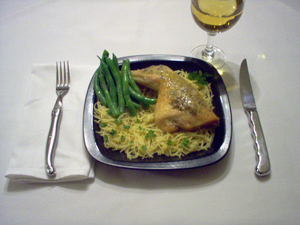

In [56]:
# testing the mapping of Val Set

test_img = modified_val_set[400]['images']
test_img.thumbnail((300,300))
test_img

### -------------------------------End of Processing----------------------------------------------------------------------------

In [57]:
from transformers import ViltProcessor, ViltForQuestionAnswering

In [58]:
from transformers import ViltConfig
config = ViltConfig.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

In [59]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [60]:
processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-mlm")
model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-mlm", id2label = reverse_mapping, label2id = mapping).to(device)

Some weights of ViltForQuestionAnswering were not initialized from the model checkpoint at dandelin/vilt-b32-mlm and are newly initialized: ['classifier.0.bias', 'classifier.3.bias', 'classifier.1.bias', 'classifier.1.weight', 'classifier.0.weight', 'classifier.3.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [61]:
from torch.utils.data import DataLoader
from datasets import Dataset
import numpy as np

In [62]:
class cric_dataset(Dataset):
    
    def __init__(self, dataset, processor):
        self.processor = processor
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self,idx):
        
        #print(idx)
        item = self.dataset[idx]

        #print(item)
        
        encodings = self.processor(images = item["images"], text = item["questions"], padding="max_length", truncation=True, return_tensors = "pt")
        encodings = {k:v.squeeze() for k,v in encodings.items()}

        labels = item['answers']
        scores = item['scores']
        
        #print(labels)
        #print(scores)
        
        targetWrapper = []
        
        # for a single data point labels is a list of integer, so just update the indices
        # else for a batch(say size 2) labels is a list of list(of indices) then second if will be executed
        
        if isinstance(labels[0],int):
                        
            targets = [0]*len(mapping)
            for label, score in zip(labels, scores):            
                targets[label] = score
            targetWrapper = targets
        
        else:
        
            for label, score in zip(labels, scores):            
                #print(label)
                #print(score)
        
                targets = [0]*len(mapping)
                targets = np.asarray(targets, dtype = float)
                targets[label] = score
                targets = list(targets)

                targetWrapper.append(targets)
            
        
        encodings["labels"] = torch.tensor(targetWrapper)
        
        return encodings

In [63]:
train_dataset_object = cric_dataset(modified_train_set, processor)

In [64]:
val_dataset_object = cric_dataset(modified_val_set, processor)

In [65]:
def collate_fn(batch):
  
    input_ids = [item['input_ids'] for item in batch]
    pixel_values = [item['pixel_values'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    token_type_ids = [item['token_type_ids'] for item in batch]
    labels = [item['labels'] for item in batch]
        
    # create padded pixel values and corresponding pixel mask
    
    encoding = processor.image_processor.pad(pixel_values, return_tensors="pt")

    # create new batch
    
    batch = {}
    
    batch['input_ids'] = torch.stack(input_ids)
    batch['attention_mask'] = torch.stack(attention_mask)
    batch['token_type_ids'] = torch.stack(token_type_ids)
    batch['pixel_values'] = encoding['pixel_values']
    batch['pixel_mask'] = encoding['pixel_mask']
    batch['labels'] = torch.stack(labels, dim = 0 )

    return batch


In [66]:
train_dataloader = DataLoader(train_dataset_object, collate_fn = collate_fn, shuffle = True, batch_size = 16)

In [67]:
val_dataloader = DataLoader(val_dataset_object, collate_fn = collate_fn, shuffle = True, batch_size = 16)

In [68]:
batch = next(iter(val_dataloader))

for k,v in batch.items():
    print(k, v.shape)
    print()
    
print(len(train_dataloader))

print(batch.keys())

input_ids torch.Size([16, 40])

attention_mask torch.Size([16, 40])

token_type_ids torch.Size([16, 40])

pixel_values torch.Size([16, 3, 576, 608])

pixel_mask torch.Size([16, 576, 608])

labels torch.Size([16, 534])

250
dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'pixel_values', 'pixel_mask', 'labels'])


In [69]:
batch = next(iter(train_dataloader))

for k,v in batch.items():
    print(k, v.shape)
    print()
    
print(len(train_dataloader))

print(batch.keys())

input_ids torch.Size([16, 40])

attention_mask torch.Size([16, 40])

token_type_ids torch.Size([16, 40])

pixel_values torch.Size([16, 3, 512, 608])

pixel_mask torch.Size([16, 512, 608])

labels torch.Size([16, 534])

250
dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'pixel_values', 'pixel_mask', 'labels'])


In [70]:
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler

In [71]:
scaler = GradScaler()

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
accumulate_step = 4

model.train()

for epoch in tqdm(range(10)):  

    print(f"Epoch: {epoch}")

    for idx, batch in enumerate(train_dataloader):

        batch = {k:v.to(device) for k,v in batch.items()}

        optimizer.zero_grad()
        
        # Implementing Mixed Precision Training
        
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(**batch)
            loss = outputs.loss
        
        print("Loss:", loss.item())

        # Gradient Accumulation
        
        if ( (idx+1) % accumulate_step ==0 ):
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

  0%|                                                        | 0/10 [00:00<?, ?it/s]

Epoch: 0


/home/aritra/miniconda3/envs/blip_vqa_base_env/lib/python3.8/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343998658/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Loss: 384.9127924833448
Loss: 384.7123657048986
Loss: 383.8314306642866
Loss: 383.8117750066649
Loss: 383.3724328549586
Loss: 384.47319861315157
Loss: 382.850088332002
Loss: 383.13182576342126
Loss: 382.70121612834475
Loss: 383.78301864645067
Loss: 382.783138167114
Loss: 385.0531997450937
Loss: 383.2969068326052
Loss: 382.9708897251026
Loss: 382.8270281348382
Loss: 383.9826548054485
Loss: 384.8071171496993
Loss: 382.93659928223747
Loss: 383.73849565504804
Loss: 384.6019128301816
Loss: 383.2361667829873
Loss: 382.76971165401153
Loss: 384.43776674382536
Loss: 384.64331320207486
Loss: 383.8066467083993
Loss: 383.9567477283996
Loss: 382.53713249322044
Loss: 384.5178484309762
Loss: 366.78201362863103
Loss: 365.6189987439037
Loss: 366.3233272489151
Loss: 367.3329236089868
Loss: 351.18340381979857
Loss: 349.7788082221519
Loss: 350.19006533392934
Loss: 349.1110274440915
Loss: 350.57323632854866
Loss: 350.2106046875305
Loss: 350.74312553182034
Loss: 350.07464952890734
Loss: 334.9130338182026
Lo

 10%|████▋                                          | 1/10 [02:29<22:22, 149.15s/it]

Loss: 54.19537370603003
Epoch: 1
Loss: 54.4510030612347
Loss: 54.204459950731476
Loss: 54.53843092993616
Loss: 54.677012792686455
Loss: 53.2089277371373
Loss: 52.95210217286337
Loss: 53.448204432512426
Loss: 52.932560332250766
Loss: 52.07260804547257
Loss: 52.19365218283124
Loss: 51.91410908352749
Loss: 52.06855920734789
Loss: 50.97123229043355
Loss: 50.853783690850264
Loss: 50.97131323354036
Loss: 51.11653080083437
Loss: 50.05702591681075
Loss: 49.84819600061161
Loss: 49.66694959153602
Loss: 50.0813212413857
Loss: 48.80790163217142
Loss: 48.60019063586211
Loss: 49.13056342114895
Loss: 48.86700550666059
Loss: 47.98906692522221
Loss: 48.04882039911033
Loss: 47.811534942141535
Loss: 47.85608849210119
Loss: 46.7934466319995
Loss: 46.7222191814546
Loss: 46.59015135631488
Loss: 47.30691701233317
Loss: 45.65052500345237
Loss: 46.06613667795597
Loss: 45.7427205710497
Loss: 45.7500068001819
Loss: 45.05772809239376
Loss: 44.96162110071727
Loss: 45.37139404480995
Loss: 44.9118143648114
Loss: 44.

 20%|█████████▍                                     | 2/10 [04:56<19:43, 147.98s/it]

Loss: 22.897118004954752
Epoch: 2
Loss: 23.238836350253436
Loss: 22.808072470792062
Loss: 23.113624572679853
Loss: 22.839219288303635
Loss: 22.667534726985615
Loss: 22.98479568568628
Loss: 23.047078397478458
Loss: 22.86632523068984
Loss: 22.269471742780503
Loss: 22.311237033343186
Loss: 22.938474350825828
Loss: 22.35877233689648
Loss: 22.177226424860745
Loss: 22.31159975383988
Loss: 22.82857042873415
Loss: 22.443123590437832
Loss: 22.324429526792365
Loss: 22.206341397505653
Loss: 22.24232376935736
Loss: 22.29854331709208
Loss: 22.34307754016907
Loss: 22.32580078570221
Loss: 21.90247862555462
Loss: 21.97489310114514
Loss: 21.752016877040347
Loss: 21.494756032367395
Loss: 22.044936491877696
Loss: 22.17742882479174
Loss: 21.88647621074782
Loss: 22.15301239781887
Loss: 21.958839755217788
Loss: 21.678185949181803
Loss: 21.80812585943955
Loss: 22.129500205360188
Loss: 21.685675185021505
Loss: 21.183080332104822
Loss: 21.59226326388665
Loss: 21.549319754921004
Loss: 21.30957519220695
Loss: 21

In [ ]:
model.eval()

In [ ]:
index = 11

In [ ]:
example = val_dataset_object[index]
print(example.keys())

In [ ]:
list1 = example['labels'].tolist()
storeIndex = []
for i in range(len(list1)):
    if list1[i] != 0:
        storeIndex.append(i)
    

In [ ]:
print(storeIndex)

for num in storeIndex:
    print(reverse_mapping[num])

In [ ]:
processor.decode(example['input_ids'])

In [ ]:
# add batch dimension + move to GPU
example = {k: v.unsqueeze(0).to(device) for k,v in example.items()}

# forward pass
outputs = model(**example)

In [ ]:
logits = outputs.logits
predicted_classes = torch.sigmoid(logits)
probs, classes = torch.topk(predicted_classes, 4)

In [ ]:
for prob, class_idx in zip(probs.squeeze().tolist(), classes.squeeze().tolist()):
  print(prob, model.config.id2label[class_idx])

In [ ]:
questionList_val[index]

In [ ]:
answerList_val[index]

In [ ]:
i = Image.open(imgPathList_val[index])
i.thumbnail((300,300))
i

In [ ]:
# Performance metrics Code

def calculateAccuracy():

    classificationResult = []

    model.eval()
    matchScore, loopCounter = 0,0

    for index in range(0,200):
        
        loopCounter += 1
        
        example = val_dataset_object[index]
        example = {k: v.unsqueeze(0).to(device) for k,v in example.items()}
        outputs = model(**example)

        logits = outputs.logits
        predicted_classes = torch.sigmoid(logits)
        probs, classes = torch.topk(predicted_classes, 1)

        print(f'T: {answerList_val[index]} <-> P: {model.config.id2label[classes.squeeze().item()]}' )

        # accuracy score
        
        if answerList_val[index] == model.config.id2label[classes.squeeze().item()]:
            matchScore += 1
        
        classificationResult.append( model.config.id2label[classes.squeeze().item()] )
        
    print(matchScore, loopCounter)
    return ((matchScore/loopCounter)*100)

In [ ]:
calculateAccuracy()